# LSTM

Steps to Implement an LSTM Model

1. Load and Parse the target and feature series
2. Formulate the series for a RNN supervised learning regression problem
3. Split into train test sets
4. Scale the series
 - no need to make the series stationary (no diffing)
5. Specify the (initial) archetecture of the LSTM Model
 - Key Components to be specified in Keras:
   - networks
   - layers
   - loss function
   - optimizer
6. Train the model
7. Produce the forecast

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
# import the data
filepath = '../../data/AMZN_1997-05-15_2022-08-17.csv'
data = pd.read_csv(filepath)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [3]:
close_df = data[['Date', 'Close']]
close_df['Date'] = pd.to_datetime(close_df['Date'])
close_df = close_df.set_index('Date')
close_df

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354
...,...
2022-08-11,140.639999
2022-08-12,143.550003
2022-08-15,143.179993


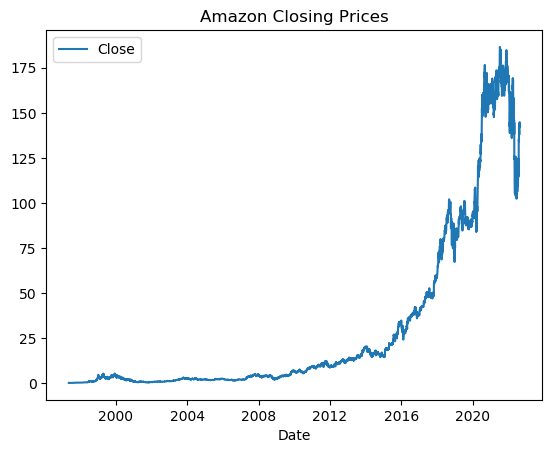

In [4]:
# Basic Visualization of the data
sns.lineplot(data=close_df)
plt.title('Amazon Closing Prices');

#### Frame as RNN supervised learning problem

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forcast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    

In [6]:
series_to_supervised(close_df, n_in=5, n_out=3)

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
Date,,,,,,,,
1997-05-22,0.097917,0.086458,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167
1997-05-23,0.086458,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563
1997-05-27,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260
1997-05-28,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260,0.075000
1997-05-29,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260,0.075000,0.075521
...,...,...,...,...,...,...,...,...
2022-08-09,134.160004,139.520004,142.570007,140.800003,139.410004,137.830002,142.690002,140.639999
2022-08-10,139.520004,142.570007,140.800003,139.410004,137.830002,142.690002,140.639999,143.550003
2022-08-11,142.570007,140.800003,139.410004,137.830002,142.690002,140.639999,143.550003,143.179993


#### Data Splitting and Scaling

In [7]:
def prep_data(series, p_test, n_lag, n_seq, stationary=False):
    '''
    series - dataset to transform
    p_test - percentage of test set size
    n_lag - number of previous days to take into account
    n_seq - number of days to predict
    stationary - boolean determining if the series should be differenced
    returns -> train, test, scaler
    '''
    # transform series into train and test sets
    ret_values = series
    if stationary:
        ret_values = series.diff().dropna()
    ret_values = ret_values.values
    ret_values = ret_values.reshape(len(ret_values), 1)
    
    # rescale series between (-1, 1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_values = scaler.fit_transform(ret_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    # Transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    # split into train and test sets
    split_val = int(len(series) * (1 - p_test))
    train, test = supervised_values[:split_val], supervised_values[split_val:]
    return train, test, scaler

#### Define model architechture

In [8]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    '''
    train - dataset to train on
    n_lag - number of previous days to take into account
    n_seq - number of days to predict
    n_batch - batch_size
    nb_epoch - epoch number
    n_neurons - number of neurons in the layer, probably going to be changed
    returns -> train, test, scaler
    '''
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    #defining the moddel
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit the model
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

#### Produce the LSTM Forecasts

In [9]:
def forecast_lstm(model, X, n_batch):
    # reshape to a 3d vector pattern of [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make the forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [10]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        print('Working on %d out of %d...' % (i, len(test)))
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

##### check up on progress

In [11]:
hist_len = 14
prediction_len = 3
train, test, scaler = prep_data(close_df, .2, hist_len, prediction_len, True)

In [12]:
model = fit_lstm(train, hist_len, prediction_len, 1, 20, 10)
model.summary()

5085/5085 [==============================] - 33s 6ms/step - loss: 1.6542e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 10)                1000      
                                                                 
 dropout (Dropout)           (1, 1, 10)                0         
                                                                 
 lstm_1 (LSTM)               (1, 10)                   840       
                                                                 
 dropout_1 (Dropout)         (1, 10)                   0         
                                                                 
 dense (Dense)               (1, 3)                    33        
                                                                 
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
___________________________________________

In [13]:
forecasts = make_forecasts(model, 1, train, test, hist_len, prediction_len)

Working on 0 out of 1255...
1/1 [==============================] - 1s 573ms/step
Working on 1 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 2 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 3 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 4 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 5 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 6 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 7 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 8 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 9 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 10 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 11 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 12 out of 1255...
1/1 [===

1/1 [==============================] - 0s 14ms/step
Working on 102 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 103 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 104 out of 1255...
1/1 [==============================] - 0s 18ms/step
Working on 105 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 106 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 107 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 108 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 109 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 110 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 111 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 112 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 113 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 16ms/step
Working on 202 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 203 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 204 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 205 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 206 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 207 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 208 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 209 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 210 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 211 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 212 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 213 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 17ms/step
Working on 302 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 303 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 304 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 305 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 306 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 307 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 308 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 309 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 310 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 311 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 312 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 313 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 402 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 403 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 404 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 405 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 406 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 407 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 408 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 409 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 410 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 411 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 412 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 413 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Working on 502 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 503 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 504 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 505 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 506 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 507 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 508 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 509 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 510 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 511 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 512 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 513 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 602 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 603 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 604 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 605 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 606 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 607 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 608 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 609 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 610 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 611 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 612 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 613 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Working on 702 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 703 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 704 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 705 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 706 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 707 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 708 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 709 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 710 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 711 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 712 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 713 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 802 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 803 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 804 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 805 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 806 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 807 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 808 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 809 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 810 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 811 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 812 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 813 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 17ms/step
Working on 902 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 903 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 904 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 905 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 906 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 907 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 908 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 909 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 910 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 911 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 912 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 913 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 15ms/step
Working on 1002 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 1003 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1004 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1005 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1006 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 1007 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1008 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1009 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1010 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1011 out of 1255...
1/1 [==============================] - 0s 18ms/step
Working on 1012 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1013 out of 1255...
1/1 

1/1 [==============================] - 0s 17ms/step
Working on 1101 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 1102 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1103 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1104 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 1105 out of 1255...
1/1 [==============================] - 0s 18ms/step
Working on 1106 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1107 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1108 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1109 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1110 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1111 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1112 out of 1255...
1/1 

1/1 [==============================] - 0s 12ms/step
Working on 1200 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1201 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1202 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1203 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1204 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1205 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1206 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1207 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1208 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1209 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1210 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1211 out of 1255...
1/1 

In [14]:
forecasts[:5]

[[0.041322593, 0.040495556, 0.039838992],
 [0.042300165, 0.041279722, 0.04054488],
 [0.042898163, 0.041769683, 0.040980328],
 [0.04307265, 0.041914027, 0.041109756],
 [0.04331027, 0.042129047, 0.041275647]]

In [15]:
def inverse_diff(last_ob, forecast):
    inverted = []
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test, stationary = False):
    inverted = []
    for i in range(len(forecasts)):
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        #invert the scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing if enabled
        temp = inv_scale
        if stationary:
            index = len(series) - n_test + i - 1
            last_ob = series.values[index]
            temp = inverse_diff(last_ob, inv_scale)
        inverted.append(temp)
    return inverted
            

In [16]:
readable = inverse_transform(close_df, forecasts, scaler, len(test)+2, True)

In [17]:
readable[-20:]

[[array([113.77869496]), array([113.78665477]), array([113.78087937])],
 [array([118.16042988]), array([118.10586219]), array([118.04916921])],
 [array([122.67074141]), array([122.56928534]), array([122.47192971])],
 [array([124.50013198]), array([124.36823766]), array([124.24616256])],
 [array([122.2755349]), array([122.1292206]), array([121.99488564])],
 [array([120.99002618]), array([120.84008844]), array([120.70037262])],
 [array([114.6721265]), array([114.53490646]), array([114.40440051])],
 [array([120.85640993]), array([120.74293221]), array([120.63463159])],
 [array([122.17956307]), array([122.07916822]), array([121.97867096])],
 [array([134.82983049]), array([134.71070034]), array([134.59657349])],
 [array([135.25229843]), array([135.11470629]), array([134.98379736])],
 [array([134.01641053]), array([133.87052414]), array([133.73341672])],
 [array([139.36268954]), array([139.20384555]), array([139.05649677])],
 [array([142.40935107]), array([142.24595182]), array([142.09465244

In [18]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' %((i+1), rmse))
        
def plot_forecasts(series, forecasts, n_test):
    plt.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    plt.show()

In [19]:
print(len(test), len(train))

1255 5085


t+1 RMSE: 2.616483
t+2 RMSE: 3.660242
t+3 RMSE: 4.505399


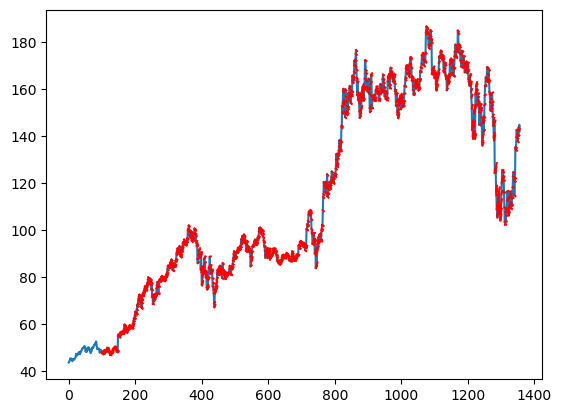

In [20]:
actual = [row[hist_len:] for row in test]
actual = inverse_transform(close_df, actual, scaler, len(test)+2, True)

evaluate_forecasts(actual, readable, hist_len, prediction_len)
plot_forecasts(close_df[5000:], readable, len(test)+2)

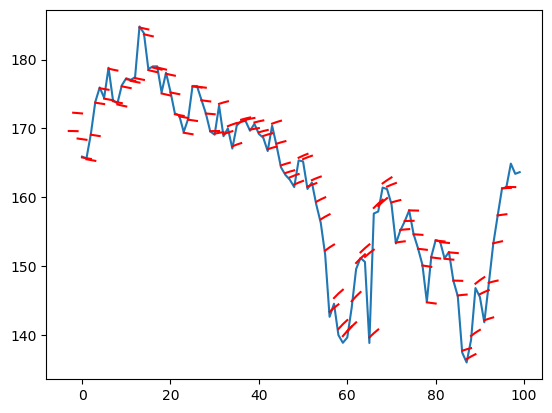

In [21]:
start_idx = -200
plt.plot(close_df.values[start_idx:start_idx + 100])
for idx, row in enumerate(readable[start_idx:start_idx + 100]):
    xaxis = [x for x in range(idx - 3, idx)]
    yaxis = row
    plt.plot(xaxis, yaxis, color='r')
plt.show();

In [22]:
pd.concat([pd.DataFrame(actual), pd.DataFrame(readable)], axis=1)

,0,1,2,0,1,2
0,[47.66450119018555],[48.345001220703125],[47.900001525878906],[47.97104054689408],[48.00240874662996],[48.02093817479909]
1,[48.345001220703125],[47.900001525878906],[47.622501373291016],[47.73115760087967],[47.77785977348685],[47.810192454606295]
2,[47.900001525878906],[47.622501373291016],[47.26300048828125],[48.42335119098425],[48.479634307324886],[48.52048197761178]
3,[47.622501373291016],[47.26300048828125],[47.30099868774414],[47.98176346719265],[48.040869154036045],[48.08424771949649]
4,[47.26300048828125],[47.30099868774414],[47.70299911499024],[47.70890987664461],[47.77222017198801],[47.81884264945984]
...,...,...,...,...,...,...
1250,[137.8300018310547],[142.69000244140625],[140.63999938964844],[139.2493395805359],[139.0883248448372],[138.94017627835274]
1251,[142.69000244140625],[140.63999938964844],[143.5500030517578],[137.6732655018568],[137.5187409222126],[137.37089627981186]
1252,[140.63999938964844],[143.5500030517578],[143.17999267578125],[142.53476218879223],[142.38111409544945],[142.23727540671825]
1253,[143.5500030517578],[143.17999267578125],[144.77999877929688],[140.47983148694038],[140.32004588842392],[140.16882459819317]


In [23]:
readable[-200:]

[[array([169.62636247]), array([169.61751646]), array([169.60059188])],
 [array([172.28149977]), array([172.22935611]), array([172.17399222])],
 [array([168.53144056]), array([168.43931871]), array([168.34908146])],
 [array([165.79201134]), array([165.67783954]), array([165.56870141])],
 [array([165.52144914]), array([165.40518717]), array([165.2941428])],
 [array([169.0933699]), array([168.98555852]), array([168.88364884])],
 [array([173.74390886]), array([173.63619851]), array([173.53629815])],
 [array([175.83620246]), array([175.72235148]), array([175.61391558])],
 [array([174.32722746]), array([174.20553655]), array([174.0886682])],
 [array([178.67231508]), array([178.53348063]), array([178.40322497])],
 [array([173.95480147]), array([173.80665772]), array([173.66671003])],
 [array([173.4762101]), array([173.3274688]), array([173.19045711])],
 [array([176.11921018]), array([175.9819385]), array([175.85200679])],
 [array([177.15430374]), array([177.02570614]), array([176.90348601])]

### Ramping up the parameters!

In [39]:
from keras.callbacks import EarlyStopping

def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    '''
    train - dataset to train on
    n_lag - number of previous days to take into account
    n_seq - number of days to predict
    n_batch - batch_size
    nb_epoch - epoch number
    n_neurons - number of neurons in the layer, probably going to be changed
    returns -> train, test, scaler
    '''
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    #defining the moddel
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    
    callbacks = [EarlyStopping(monitor='loss', patience=3)]
    
    # fit the model
    #for i in range(nb_epoch):
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False, callbacks=callbacks)
    #    model.reset_states()
    return model

In [40]:
hist_len = 14
prediction_len = 3
train, test, scaler = prep_data(close_df, .2, hist_len, prediction_len, True)

In [41]:
model = fit_lstm(train, hist_len, prediction_len, 1, 20, 50)
model.summary()

Epoch 1/20
5085/5085 [==============================] - 38s 7ms/step - loss: 1.6903e-04
Epoch 2/20
5085/5085 [==============================] - 40s 8ms/step - loss: 1.6329e-04
Epoch 3/20
5085/5085 [==============================] - 39s 8ms/step - loss: 1.6260e-04
Epoch 4/20
5085/5085 [==============================] - 33s 7ms/step - loss: 1.6223e-04
Epoch 5/20
5085/5085 [==============================] - 39s 8ms/step - loss: 1.6221e-04
Epoch 6/20
5085/5085 [==============================] - 35s 7ms/step - loss: 1.6212e-04
Epoch 7/20
5085/5085 [==============================] - 42s 8ms/step - loss: 1.6204e-04
Epoch 8/20
5085/5085 [==============================] - 33s 6ms/step - loss: 1.6208e-04
Epoch 9/20
5085/5085 [==============================] - 28s 6ms/step - loss: 1.6206e-04
Epoch 10/20
5085/5085 [==============================] - 28s 6ms/step - loss: 1.6209e-04
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Ou

In [42]:
forecasts = make_forecasts(model, 1, train, test, hist_len, prediction_len)

Working on 0 out of 1255...
1/1 [==============================] - 1s 545ms/step
Working on 1 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 2 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 3 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 4 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 5 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 6 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 7 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 8 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 9 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 10 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 11 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 12 out of 1255...
1/1 [===

1/1 [==============================] - 0s 13ms/step
Working on 102 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 103 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 104 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 105 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 106 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 107 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 108 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 109 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 110 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 111 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 112 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 113 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 202 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 203 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 204 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 205 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 206 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 207 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 208 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 209 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 210 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 211 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 212 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 213 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Working on 302 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 303 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 304 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 305 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 306 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 307 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 308 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 309 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 310 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 311 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 312 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 313 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 402 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 403 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 404 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 405 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 406 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 407 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 408 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 409 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 410 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 411 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 412 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 413 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 15ms/step
Working on 502 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 503 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 504 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 505 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 506 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 507 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 508 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 509 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 510 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 511 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 512 out of 1255...
1/1 [==============================] - 0s 19ms/step
Working on 513 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 16ms/step
Working on 602 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 603 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 604 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 605 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 606 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 607 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 608 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 609 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 610 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 611 out of 1255...
1/1 [==============================] - 0s 17ms/step
Working on 612 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 613 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 702 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 703 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 704 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 705 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 706 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 707 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 708 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 709 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 710 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 711 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 712 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 713 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Working on 802 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 803 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 804 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 805 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 806 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 807 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 808 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 809 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 810 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 811 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 812 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 813 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Working on 902 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 903 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 904 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 905 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 906 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 907 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 908 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 909 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 910 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 911 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 912 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 913 out of 1255...
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Working on 1002 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 1003 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1004 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1005 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1006 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1007 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1008 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1009 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1010 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1011 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1012 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1013 out of 1255...
1/1 

1/1 [==============================] - 0s 13ms/step
Working on 1101 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1102 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1103 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1104 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1105 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1106 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 1107 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1108 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1109 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 1110 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1111 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1112 out of 1255...
1/1 

1/1 [==============================] - 0s 13ms/step
Working on 1200 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1201 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1202 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1203 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1204 out of 1255...
1/1 [==============================] - 0s 16ms/step
Working on 1205 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1206 out of 1255...
1/1 [==============================] - 0s 14ms/step
Working on 1207 out of 1255...
1/1 [==============================] - 0s 12ms/step
Working on 1208 out of 1255...
1/1 [==============================] - 0s 15ms/step
Working on 1209 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1210 out of 1255...
1/1 [==============================] - 0s 13ms/step
Working on 1211 out of 1255...
1/1 

In [43]:
readable = inverse_transform(close_df, forecasts, scaler, len(test)+2, True)

t+1 RMSE: 2.609769
t+2 RMSE: 3.643356
t+3 RMSE: 4.481834


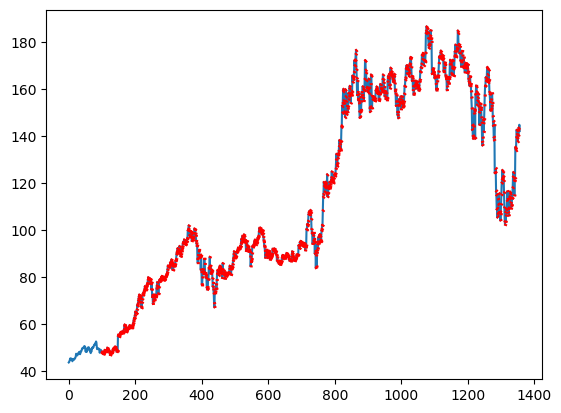

In [44]:
actual = [row[hist_len:] for row in test]
actual = inverse_transform(close_df, actual, scaler, len(test)+2, True)

evaluate_forecasts(actual, readable, hist_len, prediction_len)
plot_forecasts(close_df[5000:], readable, len(test)+2)

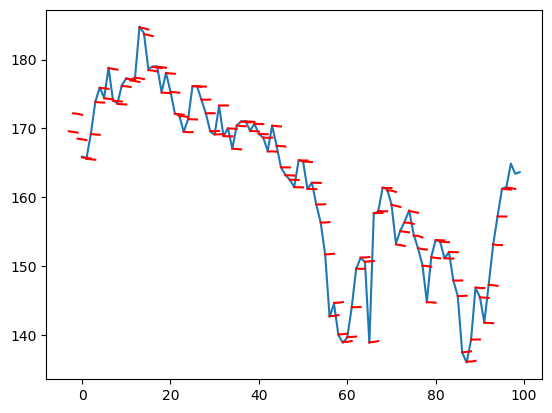

In [45]:
start_idx = -200
plt.plot(close_df.values[start_idx:start_idx + 100])
for idx, row in enumerate(readable[start_idx:start_idx + 100]):
    xaxis = [x for x in range(idx - 3, idx)]
    yaxis = row
    plt.plot(xaxis, yaxis, color='r')
plt.show();